## K-fold Cross Validation

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.labelpad'] = 10
sns.set_style("darkgrid")

In [2]:
# Loading the processed data

df = pd.read_csv('Downloads/hr_data_processed.csv')

In [3]:
# Selecting training/validation and test set

from sklearn.model_selection import train_test_split

features = ['satisfaction_level', 'last_evaluation']
X, X_test, y, y_test = train_test_split(df[features].values,df['left'].values,test_size=0.15,random_state=1)

In [4]:
# Initialising the model

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)

In [5]:
# Stratified K-fold cross validation

from sklearn.model_selection import cross_val_score

np.random.seed(1)
scores = cross_val_score(estimator=clf,X=X,y=y,cv=10)

print('accuracy = {:.3f} +/- {:.3f}'.format(scores.mean(),scores.std()))

accuracy = 0.923 +/- 0.006


In [6]:
# Custom function for class accuracies

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def cross_val_class_score(clf, X, y, cv=10):
    
    kfold = (StratifiedKFold(n_splits=cv).split(X, y))
    class_accuracy = []
    
    for k, (train, test) in enumerate(kfold):
        clf.fit(X[train], y[train])
        y_test = y[test]
        y_pred = clf.predict(X[test])
        cmat = confusion_matrix(y_test, y_pred)
        class_acc = cmat.diagonal()/cmat.sum(axis=1)
        class_accuracy.append(class_acc)
        print('fold: {:d} accuracy: {:s}'.format(k+1,str(class_acc)))
        
    return np.array(class_accuracy)

### Validation Curves

In [7]:
from sklearn.model_selection import validation_curve

clf = DecisionTreeClassifier()
max_depth_range = np.arange(3, 20, 1)

np.random.seed(1)
train_scores, test_scores = validation_curve(estimator=clf,X=X,y=y,param_name='max_depth',param_range=max_depth_range,cv=5)

In [8]:
# Function to plot the validation curve

def plot_validation_curve(train_scores,test_scores,param_range,xlabel='',log=False):
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig = plt.figure()
    
    plt.plot(param_range, train_mean, 
             color=sns.color_palette('Set1')[1], marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color=sns.color_palette('Set1')[1])

    plt.plot(param_range, test_mean, 
             color=sns.color_palette('Set1')[0], linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color=sns.color_palette('Set1')[0])

    if log:
        plt.xscale('log')
    plt.legend(loc='lower right')
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1.0)
    return fig

(0.89, 0.95)

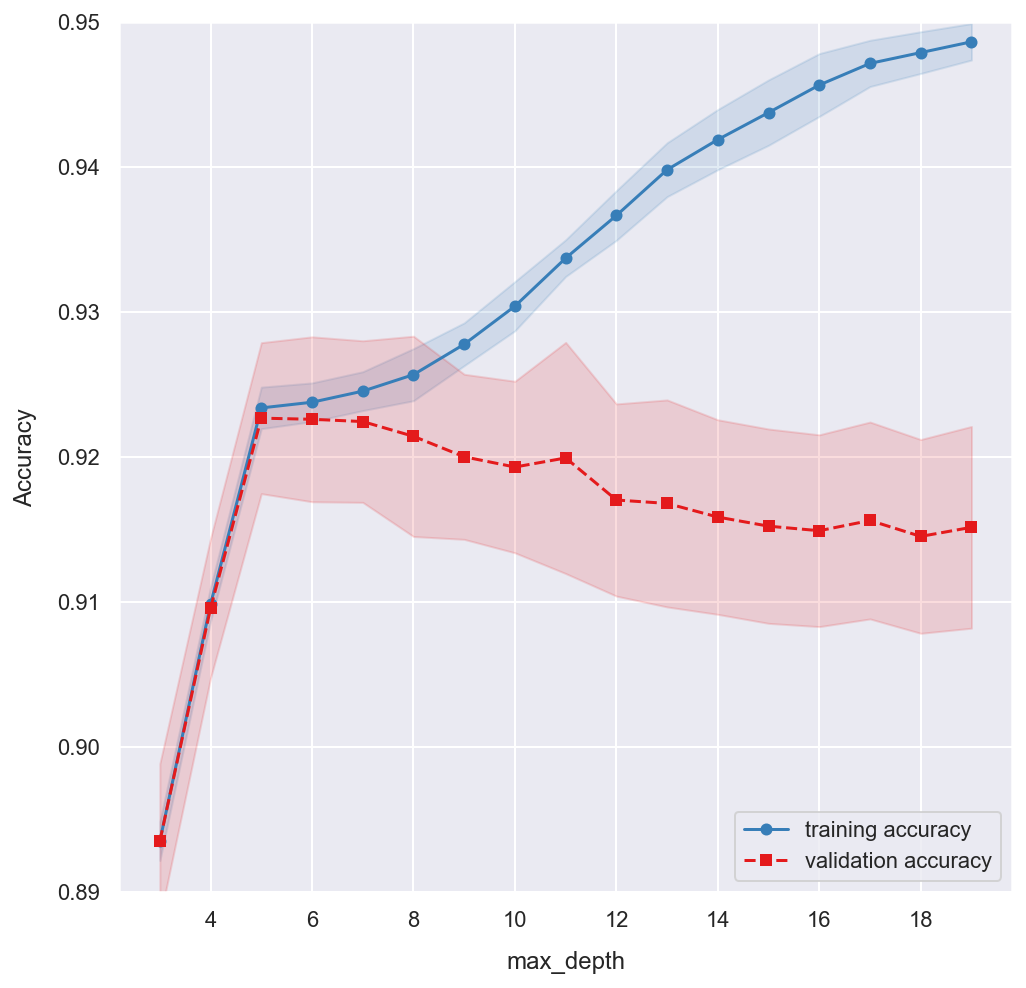

In [9]:
# Plotting the validation curve

plot_validation_curve(train_scores,test_scores,max_depth_range,xlabel='max_depth')
plt.ylim(0.89, 0.95)

### Dimensionality Reduction with PCA

In [10]:
print(df.columns)

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')


In [11]:
# Train a "quick and dirty" decision tree

features = [
    'satisfaction_level', 'last_evaluation', 'number_project',
    'average_montly_hours', 'time_spend_company', 'work_accident',
    'promotion_last_5years', 'department_IT', 'department_RandD',
    'department_accounting', 'department_hr', 'department_management',
    'department_marketing', 'department_product_mng', 'department_sales',
    'department_support', 'department_technical', 'salary_high',
    'salary_low', 'salary_medium'
]

X = df[features].values
y = df.left.values

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=10)

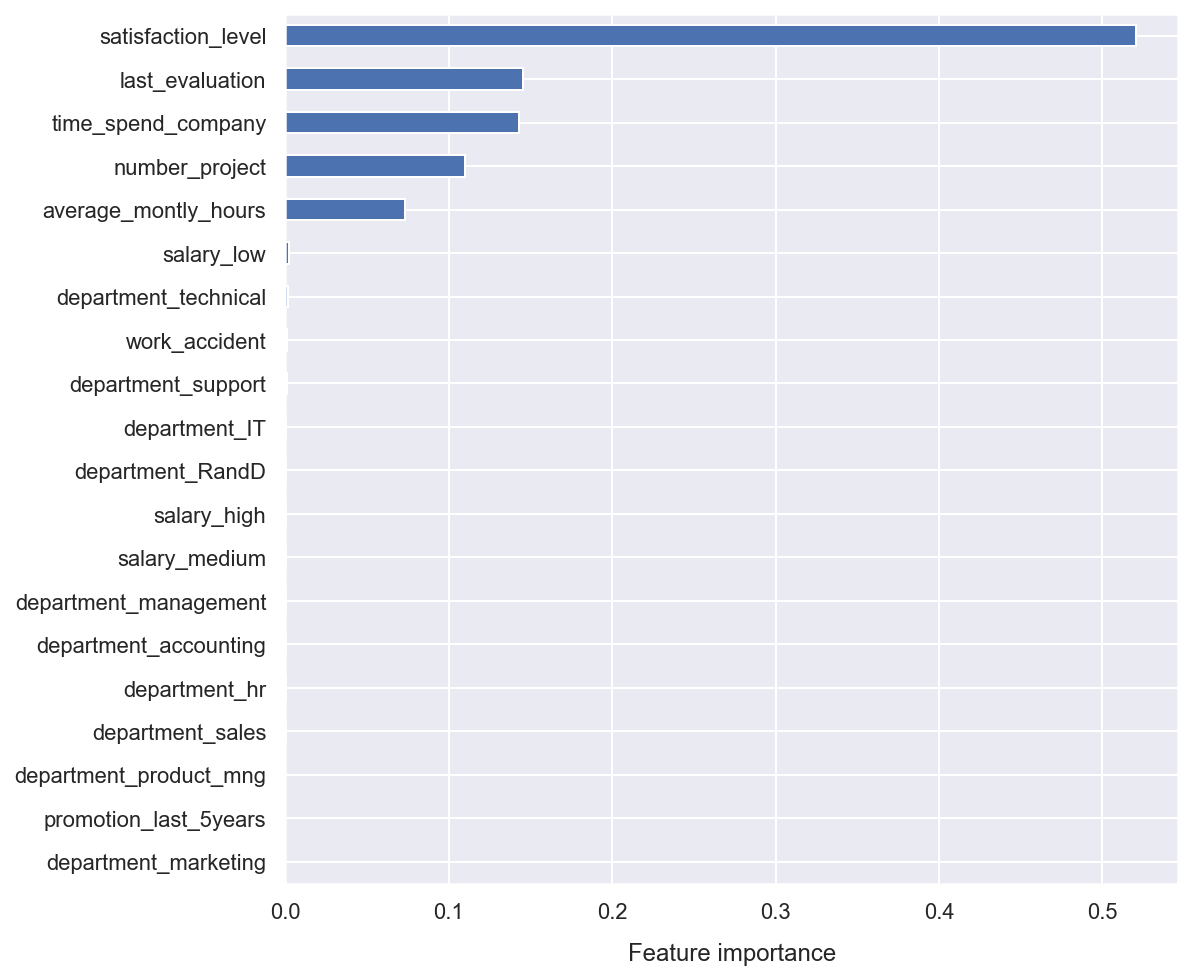

In [12]:
# Visualize the feature importances

pd.Series(clf.feature_importances_,name='Feature importance',index=df[features].columns).sort_values().plot.barh()
plt.xlabel('Feature importance')
plt.show()

In [14]:
# Select features with low / high importance

importances = list(pd.Series(clf.feature_importances_,index=df[features].columns).sort_values(ascending=False).index)

low_importance_features = importances[5:]
high_importance_features = importances[:5]

In [15]:
np.array(low_importance_features)

array(['salary_low', 'department_technical', 'work_accident',
       'department_support', 'department_IT', 'department_RandD',
       'salary_high', 'salary_medium', 'department_management',
       'department_accounting', 'department_hr', 'department_sales',
       'department_product_mng', 'promotion_last_5years',
       'department_marketing'], dtype='<U22')

In [16]:
np.array(high_importance_features)

array(['satisfaction_level', 'last_evaluation', 'time_spend_company',
       'number_project', 'average_montly_hours'], dtype='<U20')

In [17]:
# Reduce the one-hot-encoded features with PCA

from sklearn.decomposition import PCA

pca_features = [
    'salary_low', 'department_technical', 'department_support',
    'work_accident', 'salary_medium', 'department_IT',
    'department_RandD', 'salary_high', 'department_management',
    'department_accounting', 'department_hr', 'department_sales',
    'department_product_mng', 'promotion_last_5years',
    'department_marketing'
]

X_reduce = df[pca_features]

pca = PCA(n_components=3)
pca.fit(X_reduce)
X_pca = pca.transform(X_reduce)

In [18]:
X_pca.shape

(14999, 3)

In [19]:
# Add principal components to df

df['first_principle_component'] = X_pca.T[0]
df['second_principle_component'] = X_pca.T[1]
df['third_principle_component'] = X_pca.T[2]

### Training a Production Ready Model for Employee Turnover

In [21]:
# Select training / validation and test set

from sklearn.model_selection import train_test_split

features = [
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]
X, X_test, y, y_test = train_test_split(
    df[features].values,
    df['left'].values,
    test_size=0.15,
    random_state=1
)

In [22]:
%%time
# Calculate a validation curve for max_depth
# using a DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

np.random.seed(1)
clf = DecisionTreeClassifier()
max_depth_range = np.arange(2, 52, 2)
print('Training {} models ...'.format(len(max_depth_range)))
train_scores, test_scores = validation_curve(
    estimator=clf,
    X=X,
    y=y,
    param_name='max_depth',
    param_range=max_depth_range,
    cv=10,
);

Training 25 models ...
Wall time: 14.7 s


(0.95, 1.0)

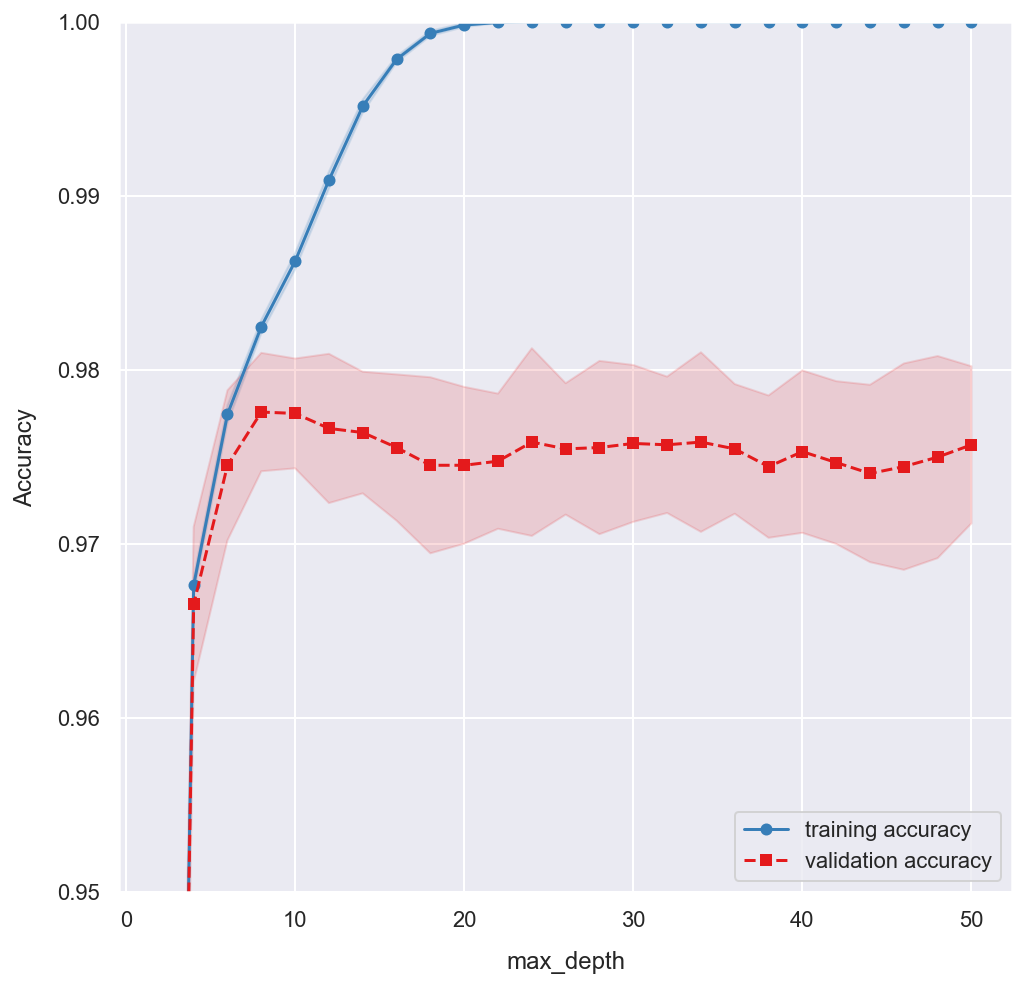

In [23]:
# Draw the validation curve

plot_validation_curve(
    train_scores,
    test_scores,
    max_depth_range,
    xlabel='max_depth',
)
plt.ylim(0.95, 1.0)

In [24]:
# Show k-fold results for the selected model:
# a decision tree with max_depth = 8

clf = DecisionTreeClassifier(max_depth=8)
np.random.seed(1)
scores = cross_val_class_score(clf, X, y)

print('accuracy = {} +/- {}'.format(
    scores.mean(axis=0),
    scores.std(axis=0),
))

fold: 1 accuracy: [0.9938208  0.91118421]
fold: 2 accuracy: [0.99588477 0.91089109]
fold: 3 accuracy: [0.99897119 0.91749175]
fold: 4 accuracy: [0.99588477 0.95379538]
fold: 5 accuracy: [0.99279835 0.91419142]
fold: 6 accuracy: [0.99588477 0.92079208]
fold: 7 accuracy: [0.99485597 0.92409241]
fold: 8 accuracy: [0.99382716 0.9339934 ]
fold: 9 accuracy: [0.99074074 0.91419142]
fold: 10 accuracy: [0.99176107 0.94059406]
accuracy = [0.99444296 0.92412172] +/- [0.00226455 0.01357943]


Text(0, 0.5, 'Accuracy')

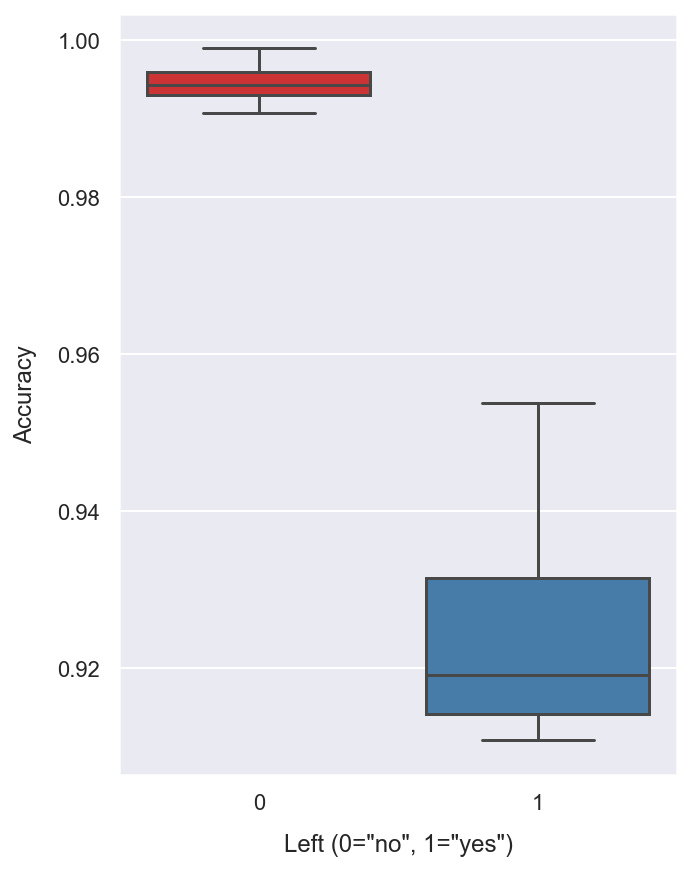

In [25]:
# Box plot of result

fig = plt.figure(figsize=(5, 7))
sns.boxplot(
    data=pd.DataFrame(scores, columns=[0, 1]),
    palette=sns.color_palette('Set1'),
)
plt.xlabel('Left (0="no", 1="yes")')
plt.ylabel('Accuracy')

In [26]:
# Evaluate performance on the test set

from sklearn.metrics import confusion_matrix

clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X, y)

y_pred = clf.predict(X_test)
cmat = confusion_matrix(y_test, y_pred)
cmat.diagonal() / cmat.sum(axis=1) * 100

array([99.23976608, 93.88888889])

In [27]:
# Train the final model on all the samples

features = [
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]
X = df[features].values
y = df['left'].values

clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=8)

In [28]:
# Print an example 

pca_features = [
    'salary_low', 'department_technical', 'work_accident',
    'department_support', 'department_IT', 'department_RandD',
    'salary_high', 'salary_medium', 'department_management',
    'department_accounting', 'department_hr', 'department_sales',
    'department_product_mng', 'promotion_last_5years',
    'department_marketing'
]

non_pca_features = [
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours'
]

bob = df.iloc[8483][pca_features + non_pca_features]
bob

salary_low                  1.00
department_technical        0.00
work_accident               0.00
department_support          0.00
department_IT               0.00
department_RandD            0.00
salary_high                 0.00
salary_medium               0.00
department_management       0.00
department_accounting       0.00
department_hr               0.00
department_sales            1.00
department_product_mng      0.00
promotion_last_5years       0.00
department_marketing        0.00
satisfaction_level          0.77
last_evaluation             0.68
time_spend_company          2.00
number_project              3.00
average_montly_hours      225.00
Name: 8483, dtype: float64

In [30]:
# Load and apply PCA transformation

pca_feature_values = pca.transform([bob[pca_features]])[0]
pca_feature_values

array([-0.67733089,  0.75837169, -0.10493685])

In [31]:
# Create prediction vector for Bob

X_bob = np.concatenate((bob[non_pca_features].values, pca_feature_values))
X_bob

array([ 7.70000000e-01,  6.80000000e-01,  2.00000000e+00,  3.00000000e+00,
        2.25000000e+02, -6.77330887e-01,  7.58371688e-01, -1.04936853e-01])

In [32]:
# Does the model predict that Bob will leave?

clf.predict([X_bob])

array([0], dtype=int64)

In [33]:
# How confident is the model in this prediction?

clf.predict_proba([X_bob])

array([[0.98462639, 0.01537361]])